In [ ]:
# next step: I need to write a function that computes the scatter at pixel 0
# then I need to run that function for all pixels and save to a file
# then I'll turn that into a script or incorporate it into the training script or something


# the problem is that this empirical method relies on some model
# I'm using test_model.model but I'm not even really sure what that is...
# the s2 is not empirical, the training set has 632 objects just like the others (no SPOCS)
# oh but the other cleaned one has 566 training set fluxes...
# is this because it's been cleaned for binaries? yes.
# so which should I use for this? the model with or without binaries?
# well it's without the binaries, but isn't that the same as gaia_rvs_model_initial?
# and what is this temp one?

In [9]:
import thecannon as tc
%pylab inline

test_model = tc.CannonModel.read('./data/cannon_models/gaia_rvs_model_cleaned.model')

test_model.training_set_flux.shape

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


(566, 2361)

In [1]:
import thecannon as tc
from astropy.io import fits
import scipy.optimize as op
%pylab inline

# load training data
training_flux = fits.open('./data/cannon_training_data/training_flux.fits')[0].data
training_sigma = fits.open('./data/cannon_training_data/training_sigma.fits')[0].data
training_ivar = 1/training_sigma**2
# load current model
model = tc.CannonModel.read('./data/cannon_models/test_model.model')

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
pixel_idx = 0
flux = training_flux[:,pixel_idx]
ivar = training_ivar[:,pixel_idx]
residuals_squared = (flux - np.dot(model.theta[pixel_idx, :], model.design_matrix.T))**2

op.brute(
    tc.fitting._scatter_objective_function, 
    (slice(0.001,0.1,0.0001),), 
    args=(residuals_squared, ivar))
# results written to s_optimizer_original.csv

0.001 , 0.35998568151863464
0.0011 , 0.36140842563881764
0.0012000000000000001 , 0.36296021924570643
0.0013000000000000002 , 0.3646393407969963
0.0014000000000000002 , 0.3664439353490621
0.0015000000000000002 , 0.36837201860471236
0.0016000000000000003 , 0.3704214812648928
0.0017000000000000003 , 0.3725900936755083
0.0018000000000000004 , 0.3748755107587136
0.0019000000000000004 , 0.37727527721613774
0.0020000000000000005 , 0.37978683298957766
0.0021000000000000003 , 0.3824075189627708
0.0022000000000000006 , 0.3847224235978768
0.002300000000000001 , 0.3876504637799606
0.0024000000000000007 , 0.39089640686064225
0.0025000000000000005 , 0.3939252527721649
0.0026000000000000007 , 0.3970486614184063
0.002700000000000001 , 0.4002635100524934
0.002800000000000001 , 0.40530422743636385
0.0029000000000000007 , 0.4125166242826335
0.003000000000000001 , 0.41860566525979254
0.003100000000000001 , 0.422157094292142
0.003200000000000001 , 0.4282703757709919
0.003300000000000001 , 0.432409457208007

array([-2.60208521e-18])

Text(0.002, 0.6, 'average empirical value')

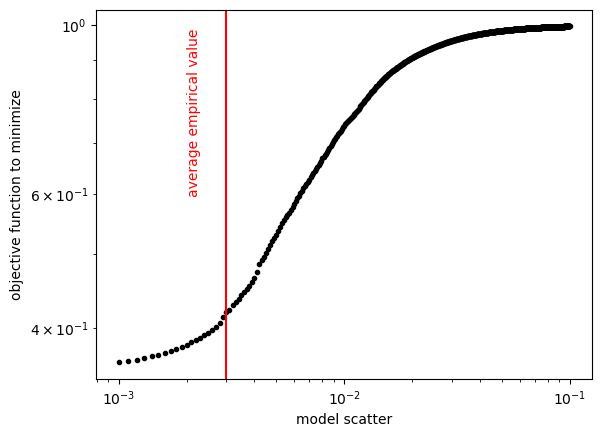

In [3]:
import pandas as pd
original = pd.read_csv('./s_optimizer_original_pixel0.csv', names=['s','objective_function'])
plot(original.s, original.objective_function, 'k.')
yscale('log');xscale('log')
ylabel('objective function to minimize');xlabel('model scatter')
axvline(0.003, color='r')
text(2e-3,6e-1,'average empirical value', rotation=90, color='r')

In [24]:
# I need these values but for the SPOCS sample
spocs_flux = pd.read_csv('./data/gaia_rvs_dataframes/spocs_flux.csv', index_col=0).values
spocs_sigma = pd.read_csv('./data/gaia_rvs_dataframes/spocs_sigma.csv', index_col=0).values
spocs_ivar = 1/spocs_sigma**2


flux_with_spocs = np.concatenate((flux, spocs_flux[pixel_idx,:]))
ivar_with_spocs = np.concatenate((ivar, spocs_ivar[pixel_idx,:]))

# decrease sigma by a factor of 1000
# this increases ivar=1/sigma^2 by a factor of 1000^2=1e6
# to see effects of just the model uncertainties

ivar_with_spocs *= 1e6

# function to compute design matrix that includes SPOCS data
from astropy.table import Table
def design_matrix_with_spocs():
    # load flux + ivar
    training_flux_with_spocs = np.concatenate((training_flux, spocs_flux.T))
    training_ivar_with_spocs = np.concatenate((training_ivar, spocs_ivar.T))
    # load labels
    training_labels = ['galah_teff', 'galah_logg', 'galah_feh','galah_alpha','galah_vbroad']
    training_set_table = Table.read('./data/label_dataframes/training_labels.csv', format='csv')
    training_set = training_set_table[training_labels].to_pandas()
    spocs_table = pd.read_csv('./data/label_dataframes/spocs_labels.csv')
    spocs_table = spocs_table[['Teff','logg','feh','alphafe_gspspec','Vbr']]
    spocs_table = spocs_table.rename(columns={
        'Teff':'galah_teff',
        'logg':'galah_logg',
        'feh':'galah_feh',
        'alphafe_gspspec':'galah_alpha',
        'Vbr':'galah_vbroad'})
    # TEMP: replace nans with zeros
    # (it would be more work to remove these)
    spocs_table['galah_alpha'] = spocs_table['galah_alpha'].fillna(0)
    # combine GALAH + SPOCS data
    training_set_with_spocs = Table.from_pandas(pd.concat((training_set, spocs_table)))

    vectorizer = tc.vectorizer.PolynomialVectorizer(training_labels, 2)

    model_with_spocs = tc.CannonModel(
        training_set_with_spocs, 
        training_flux_with_spocs, 
        training_ivar_with_spocs,
        vectorizer=vectorizer)
    return model_with_spocs.design_matrix

dot_product = np.dot(model.theta[pixel_idx, :], design_matrix_with_spocs().T)
residuals_squared_with_spocs = (flux_with_spocs - dot_product)**2


# run optimizer
op.brute(
    tc.fitting._scatter_objective_function, 
    (slice(0.001,1,0.001),), 
    args=(residuals_squared_with_spocs, ivar_with_spocs))




0.001 , 409.9539651251942
0.002 , 18.59312975253505
0.003 , 1.8520210373252348
0.004 , 0.10758587798999647
0.005 , 0.022523247290549987
0.006 , 0.16791617235708392
0.007 , 0.3207701594046593
0.008 , 0.4462222861792671
0.009000000000000001 , 0.5441687836269513
0.010000000000000002 , 0.6201863887051148
0.011 , 0.6796287130564196
0.012 , 0.726660479272959
0.013000000000000001 , 0.7643509338652864
0.014000000000000002 , 0.7949351822750204
0.015 , 0.8200462325028012
0.016 , 0.8408883468309354
0.017 , 0.8583599872552701
0.018000000000000002 , 0.8731397454086148
0.019000000000000003 , 0.8857464181045362
0.02 , 0.8965812975954714
0.021 , 0.9059582370448532
0.022000000000000002 , 0.9141252638325397
0.023 , 0.9212802960693914
0.024 , 0.9275827018315238
0.025 , 0.9331618950552819
0.026000000000000002 , 0.9381237956737032
0.027000000000000003 , 0.9425557336945765
0.028 , 0.9465302076475458
0.029 , 0.9501077910704911
0.030000000000000002 , 0.9533393993375013
0.031 , 0.9562680718398278
0.032 , 0.958

array([0.004625])

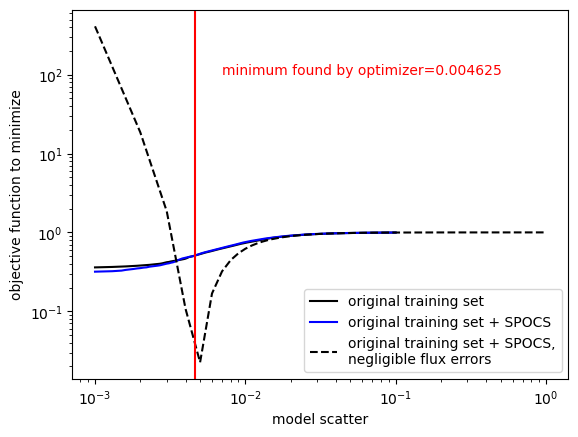

In [51]:
with_spocs = pd.read_csv('./s_optimizer_with_spocs_pixel0.csv', names=['s','objective_function'])
plot(original.s, original.objective_function, 'k-', label='original training set')
plot(with_spocs.s, with_spocs.objective_function, 'b-', label='original training set + SPOCS')

no_sigma = pd.read_csv('./s_optimizer_with_spocs_pixel0_small_sigma.csv', names=['s','objective_function'])
plot(no_sigma.s, no_sigma.objective_function, 'k--', label='original training set + SPOCS,\nnegligible flux errors')
min_objective_function = 0.004625
axvline(min_objective_function, color='r')
text(7e-3,100,'minimum found by optimizer={}'.format(min_objective_function),
     rotation=0, color='r')

ylabel('objective function to minimize');xlabel('model scatter')
#axvline(0.003, color='g')
#text(2e-3,6e-1,'average empirical value', rotation=90, color='g')
xscale('log');yscale('log')
legend(loc='lower right')

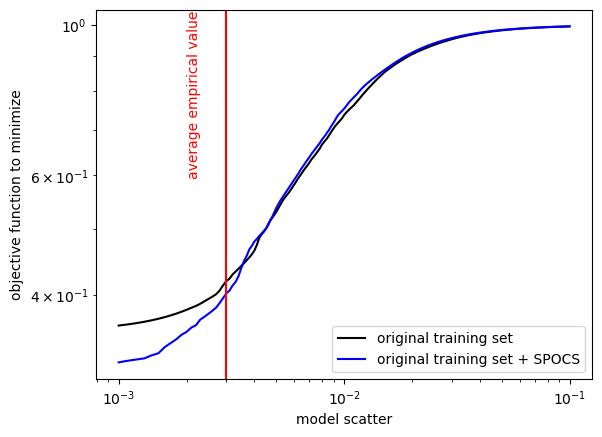

In [5]:
with_spocs = pd.read_csv('./s_optimizer_with_spocs_pixel0.csv', names=['s','objective_function'])
plot(original.s, original.objective_function, 'k-', label='original training set')
plot(with_spocs.s, with_spocs.objective_function, 'b-', label='original training set + SPOCS')
yscale('log');xscale('log')
ylabel('objective function to minimize');xlabel('model scatter')
axvline(0.003, color='r')
text(2e-3,6e-1,'average empirical value', rotation=90, color='r')
legend(loc='lower right')

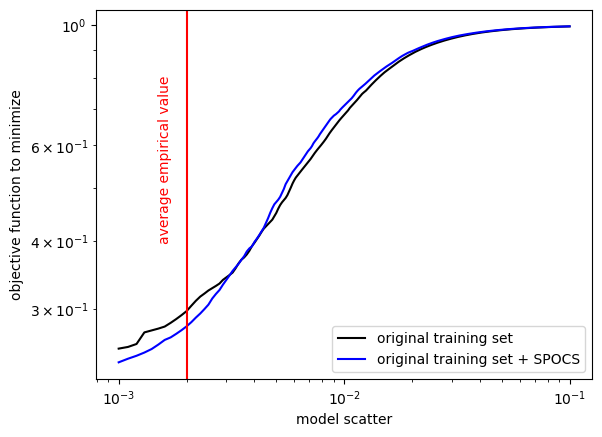

In [12]:
original1300 = pd.read_csv('./s_optimizer_original_pixel1300.csv', names=['s','objective_function'])
with_spocs1300 = pd.read_csv('./s_optimizer_with_spocs_pixel1300.csv', names=['s','objective_function'])

plot(original1300.s, original1300.objective_function, 'k-', label='original training set')
plot(with_spocs1300.s, with_spocs1300.objective_function, 'b-', label='original training set + SPOCS')
yscale('log');xscale('log')
ylabel('objective function to minimize');xlabel('model scatter')
axvline(0.002, color='r')
text(1.5e-3,4e-1,'average empirical value', rotation=90, color='r')
legend(loc='lower right')